In [3]:
# Problem 1:
"""Download the file kosarak.dat from http://fimi.ua.ac.be/data/ which contains the click-
stream data from a hungarian online news portal. Each line represents a user and each number
in the line represents a page visited by the user. Our goal is to identify the most popular
pages. It is known that the average number of pages visited by a user is less than 10.

1. Identify, using the Misra-Gries algorithm, all pages that are viewed by more than 10%
of the users. None of the pages viewed by less than 6% of the users should be identified.

2. Repeat the above using the Count Min Sketch algorithm. The error probability δ should
be less than 2%. Try to minimize the number of counters used. Use conservative updates
which is the kind of updates suggested in Assignment 5, Problem 2. You can use the
2-universal hash functions described in Assignment 5, Problem 3.
"""

from tqdm import tqdm_notebook as tqdm
from itertools import *
import collections
import numpy as np
import random 
from math import ceil

def consume(iterator, n=None):
    "Advance the iterator n-steps ahead. If n is None, consume entirely."
    # Use functions that consume iterators at C speed.
    if n is None:
        # feed the entire iterator into a zero-length deque
        collections.deque(iterator, maxlen=0)
    else:
        # advance to the empty slice starting at position n
        next(islice(iterator, n, n), None)

In [4]:
# Problem 1 part 1 approach:

# 10% heavy hitter page in the user space is really a ~1% heavy hitter in the stream because the length of the stream is the total number of pages visited by the users, which is approximately 10 times greater than the number of the users. We use 249 (1/0.004 - 1) counters - that way we guarantee that we catch all elements that are at least 0.4% hh, which includes all 0.6% and 1% hh, but some might be less than that, so we have to filter them out. What we are interested in is 1% hh. The values we get might have an error of at most 0.4% of m, so all 1% hh will have a count of at least 0.6% of m and no less-than-0.6% hh will have a count higher than 0.6% of m. So we pick the elements whose count is more than m*0.01.

class Misra_Gries():

    def __init__(self, desired_hh, permissible_hh):
        """Initialize a Misra-Gries heavy hitter detector.

        Keyword arguments:
        desired_hh -- desired heavy hitter frequency as a decimal fraction
        permissible_hh -- permissible heavy hitter frequency as a decimal fraction
        """
        self.permissible_hh = permissible_hh
        self.desired_hh = desired_hh
        self.k = int(ceil(1/(desired_hh - permissible_hh))-1)
        print(f"Creating an array of {self.k} counters for Misra-Gries heavy hitter detection.")
        self.counters = [{"elem":-1, "count":0} for i in range(self.k)]
        self.m = 0  # stream size

    def proc_elem(self, elem):
        self.m += 1
        for counter in self.counters:
            if counter["elem"] == elem: 
                counter["count"] += 1
                return 0
        ret, counter = self.exist_empty()
        if ret:
            counter["elem"] = elem
            counter["count"] += 1
            return 1
        else:
            consume(map(self.decrement, self.counters))    
    
    def decrement(self, counter):
        counter["count"] -= 1
        if counter["count"] == 0:
            counter["elem"] = -1
        return counter

    def exist_empty(self):
        zero_counters = [counter for counter in self.counters if counter["count"] == 0]
        if len(zero_counters) > 0:
            return True, zero_counters[0]
        else:
            return False, -1
    
    def get_estimates(self):
        max_error = int(self.m*(self.desired_hh - self.permissible_hh))
        error_threshold = ceil(self.m*(self.permissible_hh))
        candidates = [counter for counter in self.counters if counter["count"] > error_threshold]
        print(f"Stream size so far: {self.m}.")
        print(f"Maximum error in current estimates: {max_error}")
        print(f"For {round(self.desired_hh*100,2)}%-heavy hitters, permitting at least {round(self.permissible_hh*100,2)}%-heavy hitters, threshold count is: {error_threshold}")
        print(f"Candidate heavy hitters:")
        for i in candidates:
            print(i)

            

In [5]:
# Problem 1 part 1 results

mg = Misra_Gries(0.01, 0.006)
with open("kosarak.dat","r") as fp:
    for line in tqdm(fp, total=990002):  # 414 sec
        line = map(int, set(line.strip().split(" ")))
#         mg.m += 1
        consume(map(mg.proc_elem, line))                 
        
mg.get_estimates() # 1, 3, 6, 7, 11, 4, 218


# Output:
"""Creating an array of 249 counters for Misra-Gries heavy hitter detection.
...
Stream size so far: 8018988.
Maximum error in current estimates: 32075
For 1.0%-heavy hitters, permitting at least 0.6%-heavy hitters, threshold count is: 48114
Candidate heavy hitters:
{'elem': 3, 'count': 425642}
{'elem': 1, 'count': 173133}
{'elem': 7, 'count': 62509}
{'elem': 6, 'count': 576985}
{'elem': 11, 'count': 339676}
{'elem': 4, 'count': 53708}
{'elem': 218, 'count': 64209}
"""

Creating an array of 249 counters for Misra-Gries heavy hitter detection.



Stream size so far: 8018988.
Maximum error in current estimates: 32075
For 1.0%-heavy hitters, permitting at least 0.6%-heavy hitters, threshold count is: 48114
Candidate heavy hitters:
{'elem': 3, 'count': 425642}
{'elem': 1, 'count': 173133}
{'elem': 7, 'count': 62509}
{'elem': 6, 'count': 576985}
{'elem': 11, 'count': 339676}
{'elem': 4, 'count': 53708}
{'elem': 218, 'count': 64209}


In [8]:
# Problem 1 part 2 approach
# Create a bxl matrix where b = 2/epsilon and l = ln(1/delta) for at most epsilon error with failure probability delta. Choose epsillon and delta such that error is at most 2% with failure probability 1/(m*10) - gives probability that no failures occur for the whole stream = 0.90. Select all elments whose counts are more than m*10%. Logic: with max error of 4%, setting threshold to 10% results in selecting all 10% hh and none of the less-than-6% hh. This gives me 50x17=850 counters (low), while still guaranteeing the correct result with high probability. Possible to achieve same result with fewer counters if multiple passes are allowed to reduce error.

class CMS():
    def __init__(self, epsilon, delta):
        """Initialize a Count-Min Sketch count estimator.

        Keyword arguments:
        epsilon -- percentage error in count estimate as a decimal fraction
        delta -- probability of failure to stay within error as a decimal fraction
        """
        self.eps = epsilon
        self.delta = delta
        self.l = int(ceil(np.log(1/delta)))
        self.b = int(ceil(2/epsilon))
        print(f"Creating a {self.b}x{self.l} matrix of counters for Count-Min Sketch count estimation.")
        print(f"Epsilon = {2/self.b}, delta = {1}/{int(np.exp(self.l))}. Pr[0 failures] = {round((1-delta)**990002,4)}, E[# failures] = {round(self.delta*990002,2)}")
        self.matrix = [[[0] for i in range(self.b)] for j in range(self.l)]
        self.hashes = []
        self.get_hashes()
        self.max_elem = 0
        self.m = 0  # stream size
        
    def get_hashes(self, p=9576890767):
        p = p
        a = [random.randint(0,p) for i in range(self.l)]
        b = [random.randint(0,p) for i in range(self.l)]
        def get_h(a_i,b_i):
            def h(x):
                return ((a_i * (x % p) + b_i) % p) % self.b
            return h
        for i in range(self.l):
            self.hashes.append(get_h(a[i],b[i]))
    
    def display(self):
        for row in self.matrix:
            for val in row:
                print(val[0], end=' ')
            print()
        print()
        
    def proc_elem(self, elem):
        if elem > self.max_elem: self.max_elem = elem
        counters = []
        for i, h in enumerate(self.hashes):
            counters.append(self.matrix[i][h(elem)])
        min_val = min(counters)[0]
        for c in counters:
            if c[0] == min_val: c[0] += 1
    
    def get_estimate_for(self, elem):
        counts = [count for i,h in enumerate(self.hashes) for count in self.matrix[i][h(elem)]]
        return min(counts)

In [7]:
# Problem 1 part 2 results

cms = CMS(0.04, 1.0/(990002.0*10)) # stream length 990002 
with open("kosarak.dat","r") as fp:
    for line in tqdm(fp, total=990002):  # 111 sec
        line = (int(ch) for ch in line.strip().split(" "))
        cms.m += 1
        consume(map(cms.proc_elem, line))   
# cms.display()
for i in range(cms.max_elem):
    if cms.get_estimate_for(i) > ceil(cms.m*0.1):
        print(f"Element: {i}, count: {cms.get_estimate_for(i)}, threshold: {ceil(cms.m*0.10)}")

Creating a 50x17 matrix of counters for Count-Min Sketch count estimation.
Epsilon = 0.04, delta = 1/24154952. Pr[0 failures] = 0.9048, E[# failures] = 0.1



Element: 1, count: 197522, threshold: 99001
Element: 3, count: 450031, threshold: 99001
Element: 6, count: 601374, threshold: 99001
Element: 11, count: 364065, threshold: 99001


In [ ]:
# Problem 3:
"""Let us take k = 64 so that each cluster number is encoded by 6 bits. Thus, we will only use
64 distinct colors corresponding to the 64 cluster centers. Each pixel can now store 6 bits
of information indicating which of the 64 colors it uses. Thus, apart from the overhead of
storing the 64 colors using 64 × 3 bytes, we only use 6 bits per pixel, leading to a reduction
in space by a factor of about 4.

1. Use the above idea to convert the image Neuschwanstein small.png into an image
that uses only 64 distinct colors.

2. If you try to use the same idea for a larger image like Neuschwanstein large.png, you
will find that k-Means takes a long time since the image has over a million pixels. Use
MiniBatchKMeans instead of KMeans from Scikit-learn. Skim this short paper to learn
how MiniBatchKMeans works.
"""

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread("Neuschwanstein_small.png")
img = img[:,:,:3]  # remove the fourth coordinate alpha
plt.imshow(img)

In [115]:
# Problem 3 part 1 approach:

# Generate random starting clusters and apply Lloyd's algorithm until the clusters converge to some minima. Then swap every pixel in the image with its serving cluster center.

def get_metrics(kernel):
    def l2_metric(vec):
        return sum((i**2 for i in vec-kernel))**0.5
    return l2_metric

def iterate_lloyds(data, kernels):
    k = len(kernels)
    new_kernels = []

    metrics = [get_metrics(kernel) for kernel in kernels]
    
    service_dict = {}
    for kernel in kernels:
        service_dict[kernel] = []
        
    for i, row in enumerate(data):
        for j, px in enumerate(row):                
            dists = [metric(px) for metric in metrics]
            min_dist = min(dists)
            serving_kernel = kernels[dists.index(min_dist)]
            service_dict[serving_kernel].append(px)
            
    for kernel in service_dict:
        n = len(service_dict[kernel])
        if n > 0:
            r = sum([px[0] for px in service_dict[kernel]])/n
            g = sum([px[1] for px in service_dict[kernel]])/n
            b = sum([px[2] for px in service_dict[kernel]])/n
            new_kernels.append((r,g,b))
    
    return new_kernels
        
            
def lloyds(k, img):
    old_kernels = [tuple([random.randint(0,2**8)/255.0 for j in range(3)]) for i in range(k)]
    new_kernels = iterate_lloyds(img, old_kernels)
    n = 0
    while new_kernels != old_kernels and n < 10:
        old_kernels = new_kernels
        new_kernels = iterate_lloyds(img, old_kernels)
        n += 1
        print('|', end='')
    print(n)
    return new_kernels

def compress_img(data, kernels):
    metrics = [get_metrics(kernel) for kernel in kernels]
    compressed = []
    for i, row in enumerate(data):
        compressed.append([])
        for j, px in enumerate(row):                
            dists = [metric(px) for metric in metrics]
            min_dist = min(dists)
            index = dists.index(min_dist)
            compressed[i].append(int(index)) 
    return compressed

def show_img(data, kernels):
    img = mpimg.imread("Neuschwanstein_small.png")
    img = img[:,:,:3]
    plt.imshow(img)
    for i, row in enumerate(data):
        for j, px in enumerate(row):  
            index = data[i][j]
            kernel = kernels[index]
            img[i][j] = kernel
#             print(img[i][j])
    plt.imshow(img)

In [117]:
# Problem 3 part 1 results:

kernels = lloyds(64, img)
data = compress_img(img,kernels)
show_img(data,kernels)

||||||||||

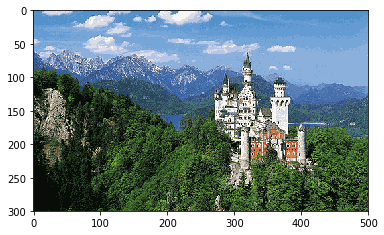

In [118]:
compressed_img = compress_img(img,kernels)
show_img(compressed_img, kernels)

In [ ]:
# Problem 3 part 2 approach:

# Same but with MiniBatchKMeans instead of Lloyd's

from sklearn.cluster import MiniBatchKMeans

img = mpimg.imread("Neuschwanstein_large.png")
img = img[:,:,:3]
plt.imshow(img)

data = img.reshape((1032*1376,3))

mbkmeans = MiniBatchKMeans(n_clusters = 64, batch_size = 10000)
mbclusters = mbkmeans.fit_predict(data)
mbcenters = mbkmeans.cluster_centers_

compressed_img = compress_img(img, mbcenters)
show_img(compressed_img, mbcenters)
